This notebook contains a QC of the input MORF library to ensure that plasmids map correctly to the expected backbone sequence (low rate of recombination) and that the barcode-TF mapping is as expected. The input library (Addgene #192821, transformed into NEB Stable *E. coli*) was sequenced by Plasmidsaurus (standard whole plasmid sequencing) to obtain the raw nanopore reads. This is the library that was used for the MORF plasmid library culture experiment.

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from Bio.Align import PairwiseAligner
from itertools import islice
from rapidfuzz import process
from rapidfuzz.distance import Levenshtein

Set figure styling.

In [2]:
sns.set_theme(
    style='ticks',
    context='paper',
    rc={"axes.spines.right": False, "axes.spines.top": False},
    font_scale=1.8,
)
np.random.seed(42)
random.seed(42)

Define functions.

In [3]:
# from https://gist.github.com/jakebiesinger/759018/1b7d6bd6967780a8bbae743760c37885bdf86467
def read_fastq(fastqfile, skip_blank=True):
    '''Parse a fastq-formatted file, yielding a (header, sequence, quality) tuple'''
    fastqiter = (l.strip('\n') for l in fastqfile)  # strip trailing newlines
    if skip_blank:
        fastqiter = filter(lambda l: l, fastqiter)  # skip blank lines
    while True:
        fqlines = list(islice(fastqiter, 4))
        if len(fqlines) == 4:
            header1, seq, header2, qual = fqlines
        elif len(fqlines) == 0:
            return
        else:
            raise EOFError("Failed to parse four lines from fastq file!")

        if header1.startswith('@') and header2.startswith('+'):
            yield header1, seq, qual
        else:
            raise ValueError("Invalid header lines: %s and %s for seq %s" % (header1, header2, seq))


COMP_TABLE = str.maketrans("ACTGN", "TGACN")

def revcomp(seq):
    '''Return the reverse complement of a DNA sequence'''
    if not set(seq).issubset({'A', 'C', 'G', 'T', 'N'}):
        raise ValueError(f"Sequence ({seq}) must only contain ACTGN")
    return seq.translate(COMP_TABLE)[::-1]

def extract_kmers(seq, k):
    kmers = []
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i + k]
        kmers.append(kmer)
    return kmers

def find_best_match(seq, query):
    kmers = extract_kmers(seq, len(query))
    best_match, score, index = process.extractOne(query, kmers, scorer=Levenshtein.distance)
    return (best_match, score, index)

def reindex(read, query, threshold=6):
    header, seq, qual = read
    match, score, index = find_best_match(seq, query)
    rc_match, rc_score, rc_index = find_best_match(revcomp(seq), query)
    if score > threshold and rc_score > threshold:
        reindexed = None
    elif score < rc_score:
        reindexed_seq = seq[index:] + seq[:index]
        reindexed_qual = qual[index:] + qual[:index]
        reindexed = (header, reindexed_seq, reindexed_qual)
    else:
        reindexed_seq = revcomp(seq)[rc_index:] + revcomp(seq)[:rc_index]
        reindexed_qual = qual[::-1][rc_index:] + qual[::-1][:rc_index]
        reindexed = (header, reindexed_seq, reindexed_qual)
    return reindexed

def encode_alignment(ref, query):
    encoded = []
    for i, j in zip(ref, query):
        if i == j:
            encoded.append(0)
        elif i != j and '-' not in {i, j}:
            encoded.append(1)
        elif i == '-' and j != '-':
            encoded.append(2)
        elif i != '-' and j == '-':
            encoded.append(3)
        else:
            raise ValueError("I wasn't expecting this")
    return encoded

def pad_lengths(d):
    max_len = max([len(v) for v in d.values()])
    for k, v in d.items():
        d[k] = v + [-1] * (max_len - len(v))

Read in nanopore reads from Plasmidsaurus raw reads fastq.

In [4]:
with open('../data/Lab_w7p_1_MORF_Stable.fastq', 'r') as f:
    fastq_reader = read_fastq(f)
    reads = [read for read in fastq_reader]
print(f"{len(reads)} reads.")

1902 reads.


Check read length distribution. Backbone is ~8.5 kb, so most reads should be larger than this. Recombination between the lentiviral LTRs gives a ~3.5 kb plasmid.

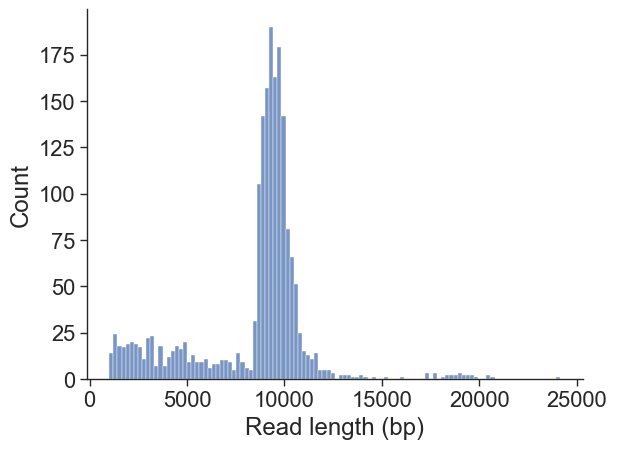

In [5]:
sns.histplot([len(read[1]) for read in reads])
plt.xlabel('Read length (bp)')
plt.savefig('images/MORF_nanopore_read_length.svg', format='svg')
plt.show()

Most reads are in the expected size range. The shorter reads could be either recombined plasmids or plasmids that had sequencing adapters transposed multiple times. Alignment to the backbone will show what's happening here: recombined plasmids should align between the two lentiviral LTRs with the ampicillin resistance gene and E. coli ori intact, while shorter fragments produced by tagmentation will have a random portion deleted.

For all reads < 8 kb and a random subset of the reads, reindex starting just downstream of the 3' LTR (between the LTRs so any recombined plasmids should contain this sequence), then align to the plasmid backbone (everything between NheI and MluI sites deleted).

In [6]:
start_seq = "AACTTGTTTATTGCAGCTTATAATGGTTAC"
short_reads = [read for read in reads if len(read[1]) < 8000]
sampled_reads = random.sample(reads, k=200)
# reindex reads
short_reindexed = [reindex(read, start_seq, threshold=6) for read in short_reads]
short_reindexed = [read for read in short_reindexed if read is not None]
print(f"{len(short_reindexed)} reindexed short reads out of {len(short_reads)} total short reads")
sampled_reindexed = [reindex(read, start_seq, threshold=6) for read in sampled_reads]
sampled_reindexed = [read for read in sampled_reindexed if read is not None]
print(f"{len(sampled_reindexed)} reindexed sampled reads out of 200 sampled reads.")

158 reindexed short reads out of 449 total short reads
162 reindexed sampled reads out of 200 sampled reads.


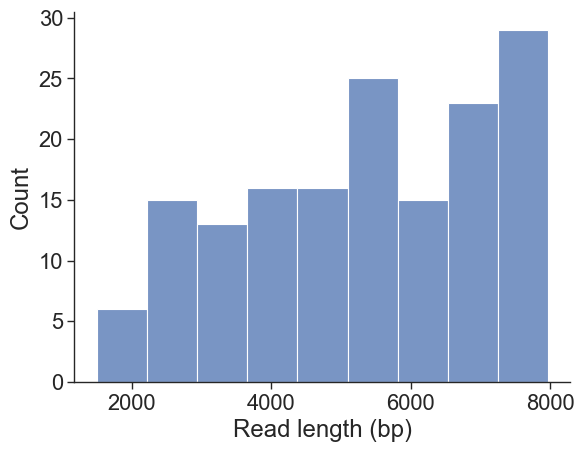

In [7]:
sns.histplot([len(read[1]) for read in short_reindexed])
plt.xlabel('Read length (bp)')
plt.show()

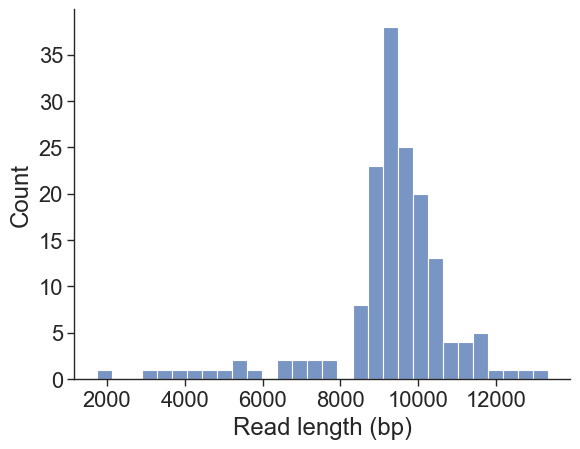

In [8]:
sns.histplot([len(read[1]) for read in sampled_reindexed])
plt.xlabel('Read length (bp)')
plt.show()

Read in expected vector sequence without insert region (everything between NheI and MluI sites deleted) and align reindexed reads to it.

In [9]:
with open("../data/MORF_backbone.txt", 'rt') as f:
    plasmid = f.readline()
plasmid = plasmid.upper()

# extend gap score is 0 because there should be a TF gene in the middle of the plasmid
aligner = PairwiseAligner(mode='global', match_score=1, mismatch_score=-1,
                          open_gap_score=-1, extend_gap_score=0)
short_encoded = dict()
for read in short_reindexed:
    alignments = aligner.align(plasmid, read[1])
    alignment = next(alignments)
    encoded = encode_alignment(alignment[0], alignment[1])
    short_encoded[read[0]] = encoded
pad_lengths(short_encoded)
short_alignments_df = pd.DataFrame.from_dict(short_encoded, orient='index')

Visualize alignment of short reads to the plasmid backbone.

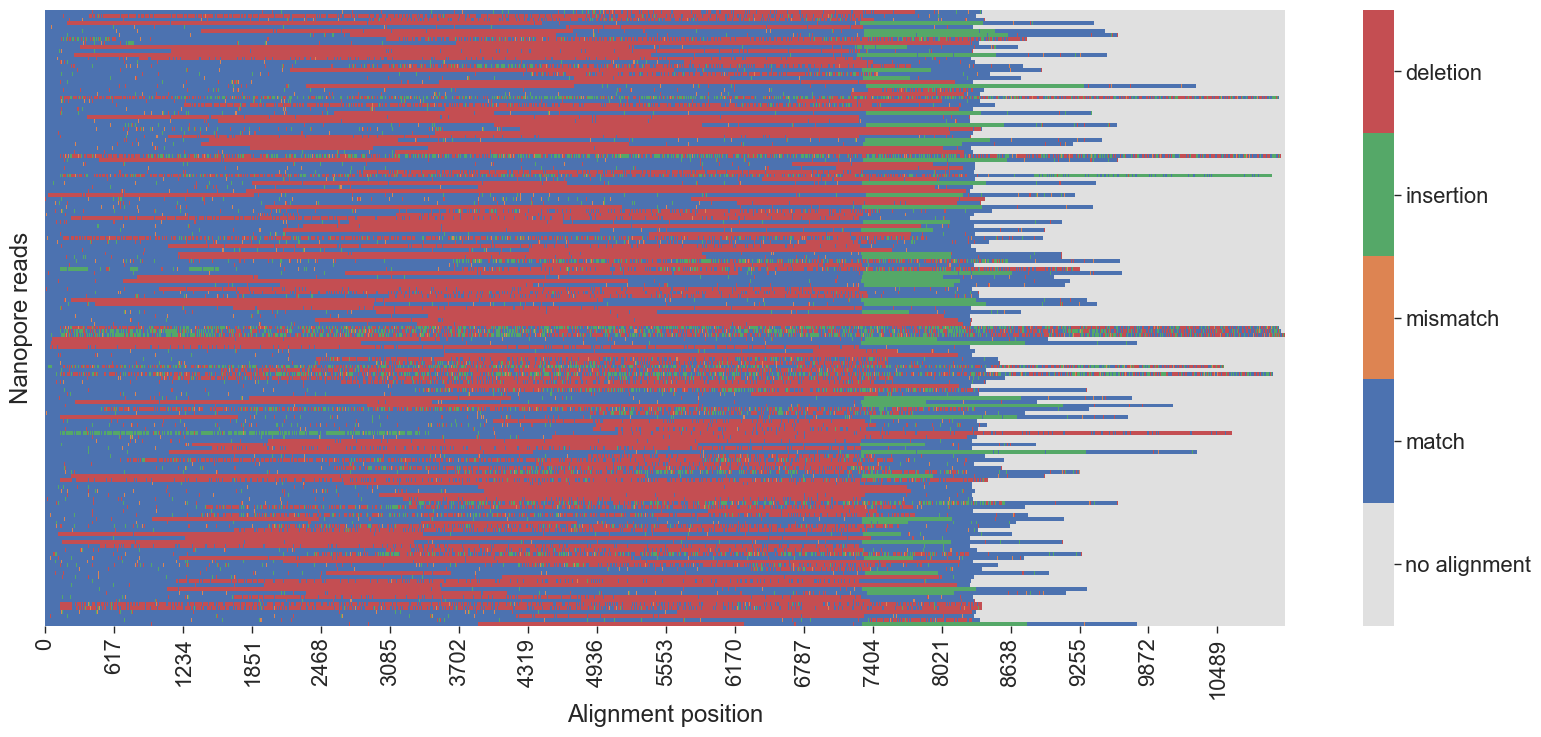

In [10]:
cmap = sns.color_palette(['#e0e0e0', '#4c72b0', '#dd8452', '#55a868', '#c44e52'])
ax = sns.heatmap(short_alignments_df, cmap=cmap)
plt.yticks([])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
colorbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
plt.gcf().set_size_inches(20, 8)
plt.ylabel('Nanopore reads')
plt.xlabel('Alignment position')
plt.show()

It's hard to see any patterns here, so try clustering the rows.

c:\Users\nmateyko\.venv\plc\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


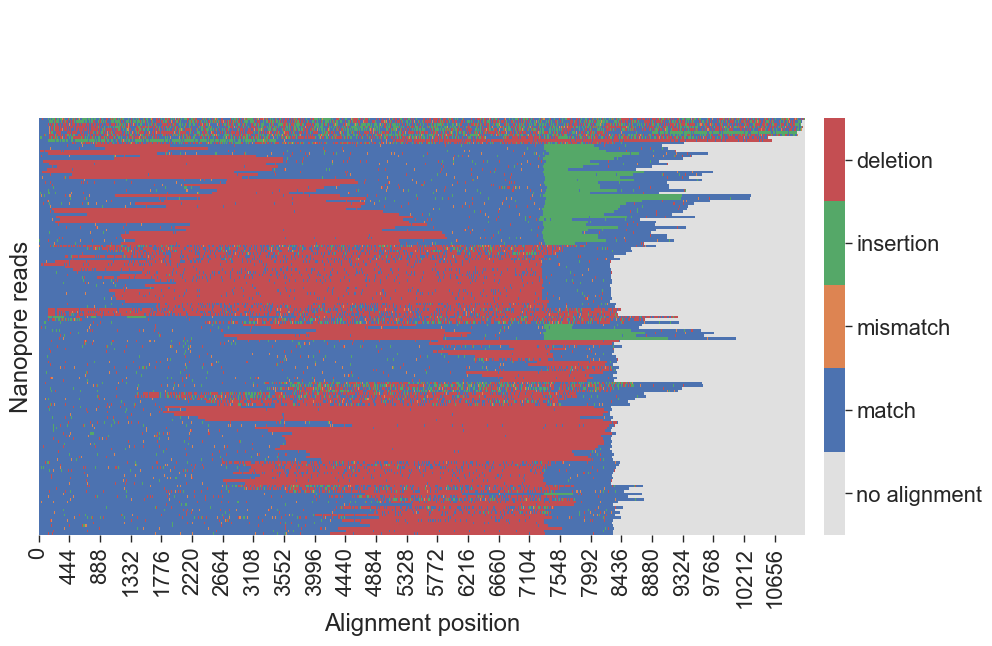

In [11]:
colors = ['#e0e0e0', '#4c72b0', '#dd8452', '#55a868', '#c44e52']
cmap = mcolors.ListedColormap(colors)
g = sns.clustermap(short_alignments_df, cmap=cmap, col_cluster=False, cbar_pos=None)

# add colorbar
norm = plt.Normalize(vmin=g.data2d.min().min(), vmax=g.data2d.max().max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = g.figure.colorbar(sm, ax=g.ax_heatmap, orientation='vertical', pad=0.02)
r = cbar.vmax - cbar.vmin
cbar.set_ticks([cbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
cbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
cbar.outline.set_visible(False)

g.ax_row_dendrogram.remove()
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_yticks([])
plt.gcf().set_size_inches(20, 6)
plt.ylabel('Nanopore reads')
plt.xlabel('Alignment position')
g.ax_heatmap.yaxis.set_label_position('left')
plt.savefig('images/MORF_nanopore_short_aligned.png', dpi=600)
plt.show()

AmpR is from ~1090-1950, and E. coli ori is from ~2120-2710. Any recombined plasmids need to at least have these sequences to be maintained, but many of the short sequences have large deletions in these regions. It seems likely that most of the short reads are due to multiple transpositions into one plasmid during plasmid sequencing prep at Plasmidsaurus, which leaves a large deletion in the alignment. It's interesting that the deletions cluster; this could be due to the transposition bias of Tn5. The 5' LTR starts at ~3400 and the 3' LTR starts around 8000. Only the third cluster from the bottom matches the expected deletion pattern for recombination between LTRs. There are only ~15 reads that match this deletion pattern so recombination between LTRs appears to be quite rare. The other short reads that couldn't be reindexed were probably mostly caused by multiple transposition but the sequence for reindexing wasn't present in them, or they could be E. coli genomic DNA contamination. Overall, it seems like there aren't many plasmids recombined between LTRs in this library.

Now make sure that most reads align properly to the backbone.

In [12]:
sampled_encoded = dict()
for read in sampled_reindexed:
    alignments = aligner.align(plasmid, read[1])
    alignment = next(alignments)
    encoded = encode_alignment(alignment[0], alignment[1])
    sampled_encoded[read[0]] = encoded
pad_lengths(sampled_encoded)
sampled_alignments_df = pd.DataFrame.from_dict(sampled_encoded, orient='index')

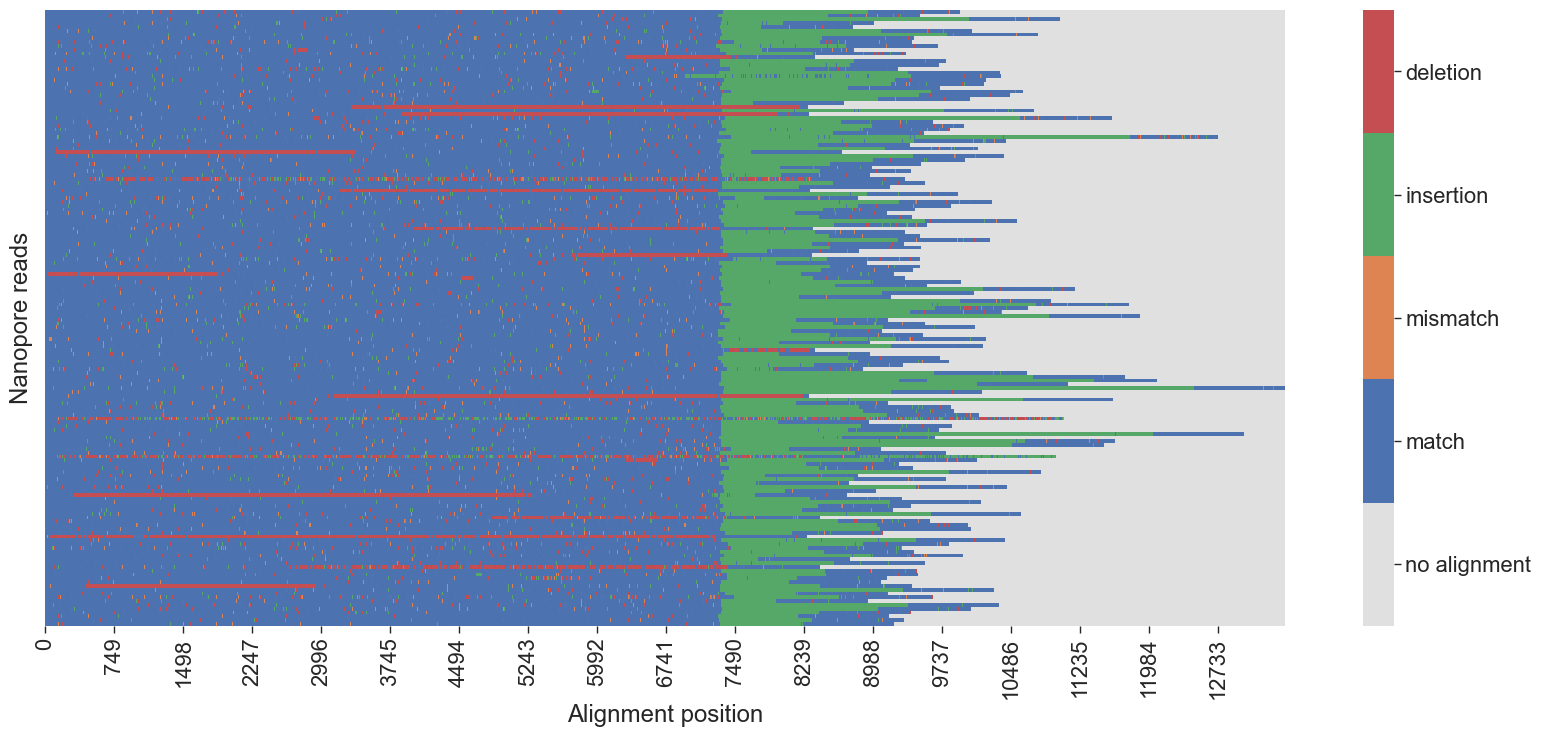

In [13]:
cmap = sns.color_palette(['#e0e0e0', '#4c72b0', '#dd8452', '#55a868', '#c44e52'])
ax = sns.heatmap(sampled_alignments_df, cmap=cmap)
plt.yticks([])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
colorbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
plt.gcf().set_size_inches(20, 8)
plt.ylabel('Nanopore reads')
plt.xlabel('Alignment position')
plt.savefig('images/MORF_nanopore_sample_aligned.png', dpi=600)
plt.show()

ORF inserts should start at ~7300 bp. It appears that most reads align as expected. Again, large deletions are probably due to how the plasmids are prepared for sequencing at Plasmidsaurus by tagmentation.

Now see if barcodes-TF pairings are as expected. First reindex the reads to end with the barcode sequence. Check that the flanking sequence on the other side of the barcode is present, and if it is, then extract the barcode and the TF ORF sequence upstream of it.

In [14]:
BC_UP = 'TTGGCTTTATATATCTTGTGGAAAGGACGA'
BC_DOWN = 'ACGCGTTAAGTCGACAATCAACCTCTGGAT'
ORF_UP = 'TTCTTCCATTTCAGGTGTCGTGAGGCTAGC'

extracted = []
for read in reads:
    reindexed_seq = reindex(read, BC_DOWN, threshold=6)
    if reindexed_seq:
        header, seq, qual = reindexed_seq
        if Levenshtein.distance(seq[-54:-24], BC_UP) <= 6:
            barcode = seq[-24:]
            orf_start_match = find_best_match(seq, ORF_UP)
            if orf_start_match[1] <= 6:
                i = orf_start_match[2]
                orf = seq[i + len(ORF_UP):-54]
                extracted.append((header, barcode, orf))
print(f"Extracted {len(extracted)} barcode-TF pairs from {len(reads)} reads.")

Extracted 1318 barcode-TF pairs from 1902 reads.


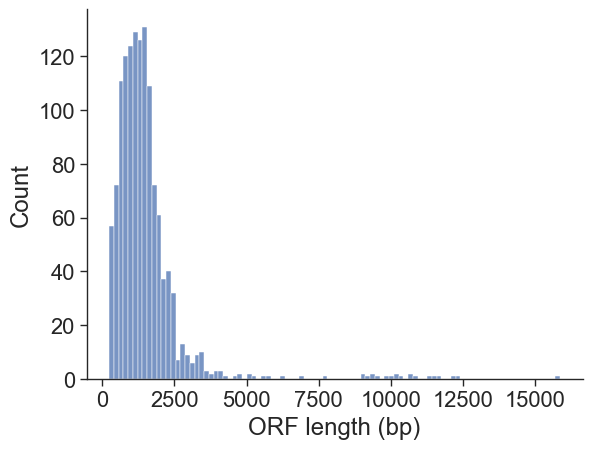

In [15]:
sns.histplot([len(x[2]) for x in extracted])
plt.xlabel('ORF length (bp)')
plt.show()

Some of the extracted ORF lengths are greater than the longest ORF in the library (~10 kb). These are probably plasmid dimers.

Now find the MORF barcode closest to the sequenced barcode and compare the sequenced ORF to the expected ORF sequence.

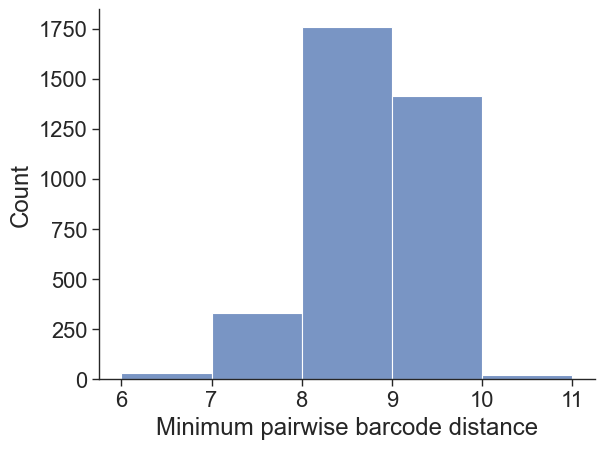

In [16]:
bc_orf_pairs = pd.read_csv('../data/200102_tf_orf_library.csv')

# find minimum pairwise distance for each barcode
min_dists = []
ref_barcodes = list(bc_orf_pairs['Barcode Sequence'])
for i, bc_1 in enumerate(ref_barcodes):
    min_dist = 100
    for j, bc_2 in enumerate(ref_barcodes):
        if i != j:
            dist = Levenshtein.distance(bc_1, bc_2)
            if dist < min_dist:
                min_dist = dist
    min_dists.append(min_dist)

sns.histplot(min_dists, bins=range(min(min_dists), max(min_dists) + 2))
plt.xlabel('Minimum pairwise barcode distance')
plt.show()

A distance threshold of 5 for matching barcodes should be good.

Find closest MORF barcode within a distance of 5, then align the sequenced ORF with the expected ORF sequence.

In [17]:
def get_closest_barcode(bc, all_barcodes):
    closest = process.extractOne(bc, all_barcodes, scorer=Levenshtein.distance)
    if closest[1] > 5:
        return None
    else:
        return closest[0]
    
all_barcodes = list(bc_orf_pairs['Barcode Sequence'])
df = pd.DataFrame(extracted, columns=['header', 'barcode', 'ORF'])
df['closest barcode'] = df['barcode'].apply(lambda x: get_closest_barcode(x, all_barcodes))
len_before = len(df)
df = df.dropna()
len_after = len(df)
print(f"Dropped {len_before - len_after} rows out of {len_before} due to no barcode match.")

Dropped 53 rows out of 1318 due to no barcode match.


In [18]:
def get_align_score(ref, query):
    aligner = PairwiseAligner(mode='global', match_score=1, mismatch_score=-1,
                              open_gap_score=-1, extend_gap_score=-1)
    alignments = aligner.align(ref, query)
    alignment = next(alignments)
    score = alignment.score
    return score

df['alignment score'] = df.apply(lambda x: get_align_score(bc_orf_pairs[bc_orf_pairs['Barcode Sequence'] == x['closest barcode']]['ORF sequence'].values[0], x['ORF']), axis=1)
df['normalized score'] = df['alignment score'] / df['ORF'].str.len()

df['random alignment score'] = df.apply(lambda x: get_align_score(bc_orf_pairs.sample(1)['ORF sequence'].values[0], x['ORF']), axis=1)
df['random normalized score'] = df['random alignment score'] / df['ORF'].str.len()

Plot distribution of length-normalized Needleman-Wunsch alignment scores.

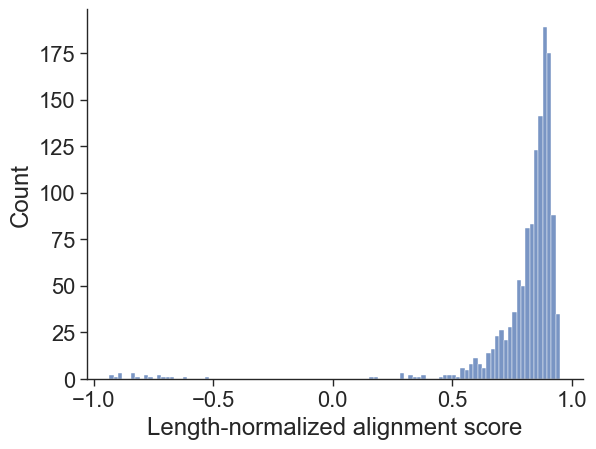

In [19]:
sns.histplot(df['normalized score'])
plt.xlabel('Length-normalized alignment score')
plt.savefig('images/MORF_nanopore_align_score.svg', format='svg')
plt.show()

Almost all sequenced ORFs align closely to the expected ORF sequence based on the sequenced barcode. It's expected that the alignment scores won't be too close to 1 due to the error rate in nanopore sequencing and because I didn't trim all flanking sequences from the extracted ORF sequences (it appears that there are different sequences flanking the ORFs in the library, so I didn't bother trying to trim everything.)

Now see what aligment scores are expected for alignment to a random ORF.

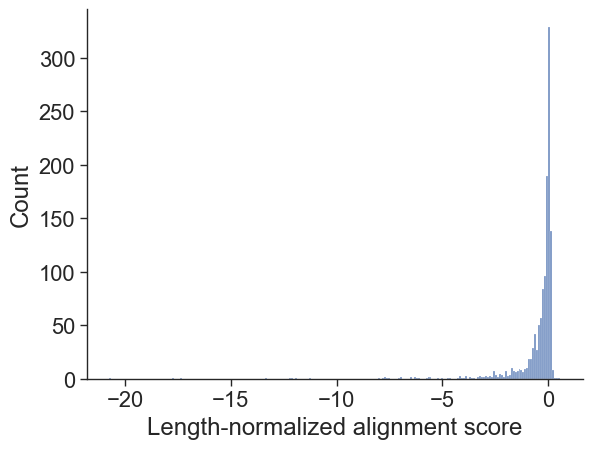

In [20]:
sns.histplot(df['random normalized score'])
plt.xlabel('Length-normalized alignment score')
plt.show()

Remove scores < -1 for easier comparison to the other histogram.

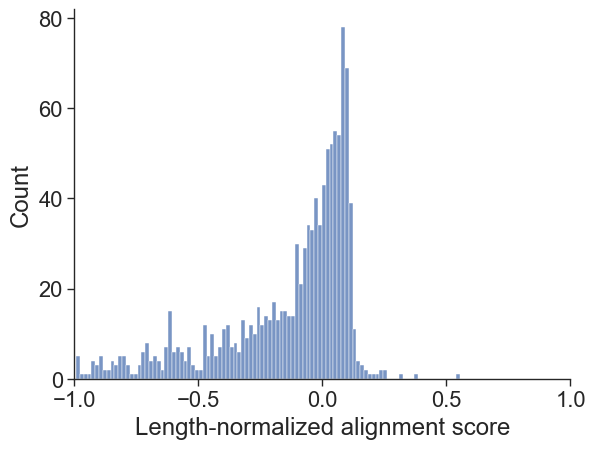

In [21]:
fig, ax = plt.subplots()
random_scores = [x for x in df['random normalized score'] if x >= -1]
sns.histplot(random_scores, bins=100, ax=ax)
ax.set_xlim(-1, 1)
plt.xlabel('Length-normalized alignment score')
plt.savefig('images/MORF_nanopore_random_align.svg', format='svg')
plt.show()

Alignment of the extracted ORFs to a random reference ORF sequence rarely gives a normalized score above 0.25. Given that most sequenced ORFs aligned to the expected reference sequence with a score >0.5, it appears that the barcode-TF mapping in the library is as expected.